In [126]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
from scipy import linalg
from mpmath import *
from numba import njit

def delta(i):
    if i == 0:
        return 1
    else:
        return 0

## Auxilliary functions for common ACFs

**Markovian Process ACF**

In [127]:
def return_Markovian_ACF(tau,T):
    ACF = np.zeros((T,T))
    alpha = np.exp(-1/tau)
    for i in range(0,T):
        for j in range(0,T):
            ACF[i,j] = alpha**np.abs(i-j)
    return ACF

## Coding the forecast matrix

In [128]:
#@njit
def optimized_matrix_inverse(matrix):
    return np.linalg.inv(matrix)

In [370]:
def Mforecast(tipo, process, param, t0, T, C_fixed):

        tau_mu = param[0]
        tau_NT = param[1]
        if tipo == "mark":
            if process == "MU":
                alpha_appo = np.exp(-1/param[0])
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
                flag = 0
            if process == "NT":
                alpha_appo = np.exp(-1/param[1])
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
                flag = 0
        if tipo == "osc":
            if process == "MU":
                alpha_mu = np.exp(-1/param[0])
                tau1_mu = param[1]
                C_appo = np.fromfunction(lambda i,j : alpha_mu**np.abs(i-j)*np.sin((i-j)/tau1_mu+np.pi/2), (T,T), dtype = float)
                flag = 0
            if process == "NT":
                alpha_NT = np.exp(-1/param[2])
                tau1_NT = param[3]
                C_appo = np.fromfunction(lambda i,j : alpha_NT**np.abs(i-j)*np.sin((i-j)/(tau1_NT)+np.pi/2), (T,T), dtype = float)
                flag = 0
                     
        if tipo == "id":
            if process == "MU":
                alpha_appo = np.exp(-1/param[0])
                C_appo = np.identity(T)
                flag = 0
            if process == "NT":
                alpha_appo = np.exp(-1/(param[0]))
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j)*np.sin((i-j)/(tau_NT)+np.pi/2), (T,T), dtype = float)
                flag = 0
        
        if tipo == "pl":
            if process == "MU":
                tau = param[0]
                gamma = param[1]
                C_appo = (np.fromfunction(lambda i, j: np.power( 1+np.absolute(i-j)/tau,-gamma), (T,T), dtype=float))
                flag = 0
            if process == "NT":
                tau = param[2]
                gamma = param[3]
                C_appo = (np.fromfunction(lambda i, j: np.power( 1+np.absolute(i-j)/tau,-gamma), (T,T), dtype=float))
                flag = 0
        
        if tipo == "fixed":
                C_appo = C_fixed
                flag = 1
            
        g = np.zeros((T-t0,t0))
        for J in range (t0+1,T+1):
            
            # In the case of a fixed ACF given, this part of the code augments the correlation matrix at each 
            # iteration, in view of evaluating the forecasts
            if(flag):
                C_last = C_appo
                C_appo = np.zeros((J,J))
                J_last = C_last.shape[0]
                for i in range (0,J_last):
                    for j in range(0,J_last):
                        C_appo[i,j] = C_last[i,j]
                if(C_appo.shape[0] > C_last.shape[0]):
                    C_appo[0,C_appo.shape[0]-1] = 0
                    C_appo[C_appo.shape[0]-1,0] = 0
                    for row in range(1,C_appo.shape[0]):
                        C_appo[row,C_appo.shape[0]-1] = C_appo[row-1,C_appo.shape[0]-2]
                    C_appo[C_appo.shape[0]-1,1:] = C_appo[1:C_appo.shape[0],C_appo.shape[0]-1]
                        
                
            C = C_appo[:J,:J]
            #print(C)
            inv_C = optimized_matrix_inverse(C)
            inv_C[np.abs(inv_C) < pow(10,-10)] = 0 ###added line for optimization
            inv_C_int = inv_C[t0:J-1,t0:J-1]
            inv_inv_C_int = optimized_matrix_inverse(inv_C_int)
            inv_inv_C_int[np.abs(inv_inv_C_int) < pow(10,-10)] = 0 ###added line for optimization
            delta_inv_C = +inv_C[:,t0:J-1].dot(inv_inv_C_int).dot(inv_C[t0:J-1,:])
            delta_inv_C[np.abs(delta_inv_C) < pow(10,-10)] = 0 ##added line for optimization
            matrix = (inv_C[J-1,J-1]-delta_inv_C[J-1,J-1])**(-1)*(inv_C-delta_inv_C)
            g[J-t0-1,:t0] = matrix[J-1,:t0]
        return g

## Coding $\mathsf{G}$ and $\mathsf{G_{/t,t-1}}$

In [130]:
def return_G(G_0_seed, alpha_G, T):
    G_0_seed = G_0_seed
    alpha_G = alpha_G
    G_seed = G_0_seed*np.fromfunction(lambda i,j : alpha_G**np.abs(j-i)*np.heaviside(i-j,1), (T,T),dtype = np.float)
    return G_seed

In [131]:
def return_G_futpast(G):
    
    T = G.shape[0]
    
    # G_{/T,T-1}
    G_futpast = np.zeros((T,T))
    
    for i in range(0,T):
        for j in range(0,T):
            dummy = T + i
            if(dummy - j >= T):
                G_futpast[i][j] = 0
            else:
                G_futpast[i][j] = G[dummy - j][0]
    
    return G_futpast

## Coding the Noise Trader's Kernels

In [334]:
#This function returns the kernels respective to the Noise Trader's trading schedule
#alpha > 0

def NTKernels(alpha, G):
    
    T = G.shape[0]
    
    G_sym = G + G.T
    
    #This can represent e_{T-1} and also e_{/T} 
    e_T = np.zeros((T,1))
    e_T[0,0] = 1
    
    ones_vec = np.ones((T,1))
    
    M = -alpha*G_sym - 2*np.matmul(e_T,e_T.T)
    M_inv = np.linalg.inv(M)
    
    # G_{/T,T-1}
    G_futpast = return_G_futpast(G)

    #COMPUTING J
    #J is the noise trader's kernel relative to the past excess demand
    j_t = np.matmul(e_T.T,alpha*np.matmul(M_inv,G_futpast) + 2*np.matmul(M_inv,np.matmul(e_T,ones_vec.T)))
    J = np.zeros((T+1,T))

    for i in range(0,T+1):
        dummy = T - i
        J[dummy,:dummy] = j_t[0,:dummy]
     
    #COMPUTING J_IT
    #J_IT is the noise trader's kernel relative to the past informed trader's demand 
    
    #F_IT = Mforecast("mark","MU",[1,1],T,2T)
    #F_IT[np.abs(F_IT) < pow(10,-15)] = 0
    
    #We are using the hypothesis that the noise trader does not know how to forecast the IT's trades
    F_IT = np.zeros((T,T))
    
    #J_IT is the noise trader's kernel relative to the past informed trader's demand 
    j_IT = np.matmul(e_T.T,alpha*np.matmul(M_inv,np.matmul(G,F_IT)) - 2*np.matmul(M_inv,np.matmul(e_T,ones_vec.T)))
    J_IT = np.zeros((T+1,T))
    
    for i in range(0,T+1):
        dummy = T - i
        J_IT[dummy,:dummy] = j_IT[0,:dummy]
        
    #COMPUTING J_TGT
    #J_TGT is the noise trader's kernel relative to the past target portolio's demand
    j_TGT = np.matmul(e_T.T,-2*np.matmul(M_inv,np.matmul(e_T,np.ones((T+1,1)).T)))
    J_TGT = np.zeros((T+1,T+1))
    
    for i in range(0,T+1):
        dummy = T - i
        J_TGT[dummy,:dummy+1] = j_TGT[0,:dummy+1]
    
    return J,J_IT,J_TGT

## Coding the Informed Trader's Kernels

In [335]:
#This function returns the kernels respective to the Informed Trader's trading schedule
#ACF_NT is the auto-correlation matrix of the noise trader's trades

def ITKernels(G, ACF_NT, F_MU, is_rational, tau_NT):
    
    T = G.shape[0]
    
    G_sym = G + G.T
    G_sym_inv = np.linalg.inv(G_sym)
    
    #This can represent e_{T-1} and also e_{/T} 
    e_T = np.zeros((T,1))
    e_T[0,0] = 1
    
    ones_vec = np.ones((T,1))
    
    # G_{/T,T-1}
    G_futpast = return_G_futpast(G)
    
    #COMPUTING K
    #K is the informed trader's kernel relative to the past excess demand
    k_t = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,G_futpast))
    K = np.zeros((T+1,T))
    
    for i in range(0,T+1):
        dummy = T - i
        K[dummy,:dummy] = k_t[0,:dummy]
        
    #COMPUTING K_NT
    #K_NT is the informed trader's kernel relative to the past noise trader's demand
    if is_rational == True:
        F_NT = -np.flip(np.flip(Mforecast('fixed','_',[_,_],T,2*T,ACF_NT),1),0)
    else:
        F_NT = -np.flip(np.flip(Mforecast("mark","NT",[_,tau_NT],T,2*T,_),1),0)
    
    k_NT = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,np.matmul(G,F_NT)))
    K_NT = np.zeros((T+1,T))
    
    for i in range(0,T+1):
        dummy = T - i
        K_NT[dummy,:dummy] = k_NT[0,:dummy]
        
    #COMPUTING K_MU
    #K_MU is the informed trader's kernel relative to the past dividends realizations    
    k_MU = np.matmul(e_T.T,np.matmul(G_sym_inv,np.matmul(np.ones((T,T)),F_MU)))
    K_MU = np.zeros((T+1,T))
    
    for i in range(0,T+1):
        dummy = T - i
        K_MU[dummy,:dummy] = k_MU[0,:dummy]
    
    
    return K, K_NT, K_MU

In [134]:
#This function returns the kernels respective to the Informed Trader's trading schedule
#ACF_NT is the auto-correlation matrix of the noise trader's trades

#def ITKernelsSimplified(G, F_MU):
#    
#    T = G.shape[0]
#    
#    G_sym = G + G.T
#    G_sym_inv = np.linalg.inv(G_sym)
#    
#    #This can represent e_{T-1} and also e_{/T} 
#    e_T = np.zeros((T,1))
#    e_T[0,0] = 1
#    
#    ones_vec = np.ones((T,1))
#    
#    # G_{/T,T-1}
#    G_futpast = return_G_futpast(G)
#    
#    #COMPUTING K
#    #K is the informed trader's kernel relative to the past excess demand
#    k_t = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,G_futpast))
#    K = np.zeros((T+1,T))
#    
#    for i in range(0,T+1):
#        dummy = T - i
#        K[dummy,:dummy] = k_t[0,:dummy]
#        
#    #COMPUTING K_MU
#    #K_MU is the informed trader's kernel relative to the past dividends realizations    
#    k_MU = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,np.matmul(np.ones((T,T)),F_MU)))
#    K_MU = np.zeros((T+1,T))
#    
#    for i in range(0,T+1):
#        dummy = T - i
#        K_MU[dummy,:dummy] = k_MU[0,:dummy]
#    
#    
#    return K, K_MU

## Coding the  $\mathsf{D}s$ matrices

In [336]:
def return_Ds(G, alpha, ACF_NT, F_MU):
    
    T = G.shape[0]
    
    J, J_IT, J_TGT = NTKernels(alpha, G)
    
    K, K_NT, K_MU = ITKernels(G, ACF_NT, F_MU, True, _)
    
    I = np.identity(T+1)
    
    L = np.zeros((T,T+1))
    L[:T,:T] = np.identity(T)
    
    aux_1 = np.linalg.inv(I - np.matmul(K,L))
    aux_2 = np.linalg.inv(I - np.matmul(J,L))
        
    X = I - np.matmul(J,L) - np.matmul(J + J_IT, np.matmul(L, np.matmul(aux_1, np.matmul(K + K_NT, L))))
    
    Y = I - np.matmul(K,L) - np.matmul(K + K_NT, np.matmul(L, np.matmul(aux_2, np.matmul(J + J_IT, L))))
    
    X_inv = np.linalg.inv(X)
    Y_inv = np.linalg.inv(Y)
    
    #Market Maker's Ds
    D_MU = np.matmul(np.matmul(X_inv, np.matmul(J+J_IT, np.matmul(L,aux_1))) + Y_inv, K_MU)
    
    D_TGT = np.matmul(np.matmul(Y_inv, np.matmul(K+K_NT, np.matmul(L,aux_2))) + X_inv, J_TGT)
    
    #Noise Trader's Ds
    D_MU_NT = np.matmul(X_inv,np.matmul(J+J_IT,np.matmul(L,np.matmul(aux_1,K_MU))))
    
    D_TGT_NT = np.matmul(X_inv,J_TGT) 
    
    #Informed Trader's Ds
    D_MU_IT = np.matmul(Y_inv,K_MU)
    
    D_TGT_IT = np.matmul(Y_inv,np.matmul(K+K_NT,np.matmul(L,np.matmul(aux_2,J_TGT))))
    
    return D_MU, D_TGT, D_MU_NT, D_TGT_NT, D_MU_IT, D_TGT_IT

In [337]:
#def return_Ds_simplified(G, alpha, F_MU, ACF_MU, ACF_TGT):
#    
#    T = G.shape[0]
#    
#    J, J_IT, J_TGT = NTKernels(alpha, G)
#    
#    K, K_MU = ITKernelsSimplified(G, F_MU)
#    
#    I = np.identity(T+1)
#    
#    L = np.zeros((T,T+1))
#    L[:T,:T] = np.identity(T)
#    
#    aux_1 = np.linalg.inv(I - np.matmul(K,L))
#    aux_2 = np.linalg.inv(I - np.matmul(J,L))
#    
#    X = I - np.matmul(J,L) - np.matmul(J + J_IT, np.matmul(L, np.matmul(aux_1, np.matmul(K , L))))
#    
#    #Noise Trader's Ds
#    D_MU_NT = np.matmul(X_inv,np.matmul(J+J_IT,np.matmul(L,np.matmul(aux_1,K_MU))))
#    
#    D_TGT_NT = np.matmul(X_inv,J_TGT) 
#    
#    #Evaluating ACF_NT
#    ACF_NT = return_ACF_NT_simplified(G, ACF_MU, ACF_TGT, D_MU_NT, D_TGT_NT)
#        
#    
#    Y = I - np.matmul(K,L) - np.matmul(K + K_NT, np.matmul(L, np.matmul(aux_2, np.matmul(J + J_IT, L))))
#    
#    X_inv = np.linalg.inv(X)
#    Y_inv = np.linalg.inv(Y)
#    
#    #Market Maker's Ds
#    D_MU = np.matmul(np.matmul(X_inv, np.matmul(J+J_IT, np.matmul(L,aux_1))) + Y_inv, K_MU)
#    
#    D_TGT = np.matmul(np.matmul(Y_inv, np.matmul(K+K_NT, np.matmul(L,aux_2))) + X_inv, J_TGT)
#    
#
#    #Informed Trader's Ds
#    D_MU_IT = np.matmul(Y_inv,K_MU)
#    
#    D_TGT_IT = np.matmul(Y_inv,np.matmul(K+K_NT,np.matmul(L,np.matmul(aux_2,J_TGT))))
#    
#    return D_MU, D_TGT, D_MU_NT, D_TGT_NT, D_MU_IT, D_TGT_IT

## Coding the ACFs

In [338]:
def return_ACF_NT(G, ACF_MU, ACF_TGT, Ds):    

    D_MU_NT = Ds[2]
    D_TGT_NT = Ds[3]
    
    ACF_NT = np.matmul(D_TGT_NT, np.matmul(ACF_TGT, D_TGT_NT.T)) + np.matmul(D_MU_NT, np.matmul(ACF_MU, D_MU_NT.T))
        
    return ACF_NT

In [339]:
#def return_ACF_NT_simplified(G, ACF_MU, ACF_TGT, D_MU_NT, D_TGT_NT):
#    
#    ACF_NT = np.matmul(D_TGT_NT, np.matmul(ACF_TGT, D_TGT_NT.T)) + np.matmul(D_MU_NT, np.matmul(ACF_MU, D_MU_NT.T))
#    
#    return ACF_NT

In [340]:
def return_ACF_IT(G, ACF_MU, ACF_TGT, Ds):
    T = G.shape[0]
    
    D_MU_IT = Ds[4]
    D_TGT_IT = Ds[5]
    
    ACF_IT = np.matmul(D_TGT_IT, np.matmul(ACF_TGT, D_TGT_IT.T)) + np.matmul(D_MU_IT, np.matmul(ACF_MU, D_MU_IT.T))
        
    return ACF_IT

In [341]:
def return_ACF_Q(G,ACF_MU,ACF_TGT, Ds):
    T = G.shape[0]
    
    D_MU = Ds[0]
    D_TGT = Ds[1]
    
    ACF_Q = np.matmul(D_TGT, np.matmul(ACF_TGT, D_TGT.T)) + np.matmul(D_MU, np.matmul(ACF_MU, D_MU.T))
        
    return ACF_Q

## Coding the Kalman Filter used by the Market Maker

In [342]:
def kalman_filter(G, tau_MU, ACF_Q, D_MU):
    
    T = G.shape[0]
    
    L = np.zeros((T,T+1))
    L[:T,:T] = np.identity(T)
    
    ACF_MU = return_Markovian_ACF(tau_MU, T+1)
    
    ACF_Q_inv = np.linalg.inv(ACF_Q)
    aux = (np.matmul(D_MU,L)).T
    
    return np.matmul(ACF_MU, np.matmul(aux,ACF_Q_inv))

## Coding the equilibrium equation - A self-consistent equation for G

In [345]:
def new_G_from_equilibrium(G,K,F_MU):
    
    T = G.shape[0]
    
    g = np.zeros((1,T))

    for s in range(0,T):
        sum_aux = 0
        for t_prime in range(0,T):
            for t_two_primes in range(0,T):
                sum_aux = sum_aux + F_MU[t_prime,t_two_primes]*K[t_two_primes,s]
        g[0,s] = sum_aux
    
    G = np.zeros((T,T))
    G[:,[0]] = g.T
    
    for p in range(1,T):
        G[p:,p] = g[0,:T-p].T
        
    
    return G        

## Numerical Solvers - Rational and Irrational Noise Traders

In [346]:
def numerical_solver_rational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, tau_MU, ACF_TGT):
    
    G = return_G(G_0_seed, alpha_G, T)
    
    ACF_MU = return_Markovian_ACF(tau_MU, T)
    F_MU = -np.flip(Mforecast('mark','MU',[tau_MU,_],T,2*T,_),1)
    
    G_s = []
    ACFs_NT = []
    ACFs_Q = []
    ACFs_IT = []
    
    for iteration in range(0,T_it):
        
        G_s.append(G[:,0])
        
        if(iteration == 0):
            ACF_NT = return_Markovian_ACF(10,T+1)
   
        Ds = return_Ds(G, alpha, ACF_NT, F_MU)
        
        ACF_Q = return_ACF_Q(G, ACF_MU, ACF_TGT, Ds)
        
        K = kalman_filter(G, tau_MU, ACF_Q, Ds[0])
        
        G = new_G_from_equilibrium(G,K,F_MU) 
        
        ACF_NT = return_ACF_NT(G, ACF_MU, ACF_TGT, Ds)
        ACF_IT = return_ACF_IT(G, ACF_MU, ACF_TGT, Ds)
        
        ACFs_IT.append(ACF_IT)
        ACFs_NT.append(ACF_NT)
        ACFs_Q.append(ACF_Q)
        
        print(f"This is iteration: {iteration + 1}\n")
        

    return G, G_s, ACFs_NT, ACFs_IT, ACFs_Q

In [347]:
def numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, tau_MU, tau_NT):
    
    G = return_G(G_0_seed, alpha_G, T)
    
    ACF_MU_T_plus_1 = return_Markovian_ACF(tau_MU, T+1)
    ACF_NT_T_plus_1 = return_Markovian_ACF(tau_NT, T+1)
    F_MU = -np.flip(np.flip(Mforecast('mark','MU',[tau_MU,_],T,2*T,_),1),0)
    
    G_s = []
    ACFs_Q = []
    
    I = np.identity(T+1)
    
    L = np.zeros((T,T+1))
    L[:T,:T] = np.identity(T)

    for iteration in range(0,T_it):
        
        G_s.append(G[:,0])
        
        #Computing IT Kernels
        K, K_NT, K_MU = ITKernels(G,_, F_MU, False, tau_NT)
        
        aux1 = np.linalg.inv(I - np.matmul(K,L))
        aux2 = I + np.matmul(K_NT,L)
        
        D_MU = np.matmul(aux1,K_MU)
        
        aux3 = np.matmul(D_MU,L)

        ACF_Q = np.matmul(aux3, np.matmul(ACF_MU_T_plus_1,aux3.T)) + np.matmul(aux1, np.matmul(aux2, np.matmul(ACF_NT_T_plus_1, np.matmul(aux2.T,aux1.T))))
        
        ACFs_Q.append(ACF_Q)
        
        Kalman = kalman_filter(G, tau_MU, ACF_Q, D_MU)
        
        G = new_G_from_equilibrium(G,Kalman,F_MU) 
        
        print(f"This is iteration: {iteration + 1}\n")
        

    return G, G_s, ACFs_Q

## Analysis of results - Rational Noise Trader

**Iterating the self-consistent equation**

In [348]:
T = 10
T_it = 100
G_0_seed = 40
alpha_G = 0.8
alpha = 0.05
tau_MU = 20
ACF_TGT = np.identity(T+1)

G, G_s, ACFs_NT, ACFs_IT, ACFs_Q = numerical_solver_rational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, tau_MU, ACF_TGT)

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20

This is iteration: 21

This is iteration: 22

This is iteration: 23

This is iteration: 24

This is iteration: 25

This is iteration: 26

This is iteration: 27

This is iteration: 28

This is iteration: 29

This is iteration: 30

This is iteration: 31

This is iteration: 32

This is iteration: 33

This is iteration: 34

This is iteration: 35

This is iteration: 36

This is iteration: 37

This is iteration: 38

This is iteration: 39

This is iteration: 40

This is iteration: 41

This is iteration: 42

This is iteration: 43

This is iteration: 4

**Plotting the last 5 propagators found**

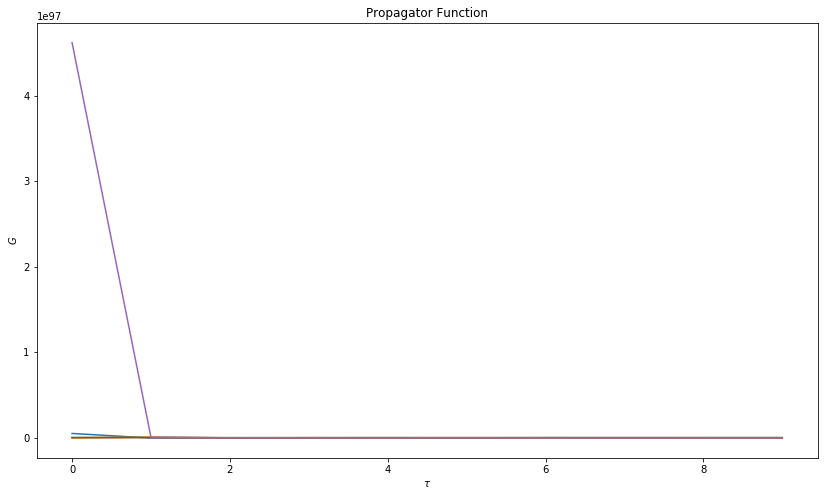

In [349]:
figure1 = plt.figure(figsize = (14,8))
plt.title("Propagator Function")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G$")
for i in range(T_it-5,T_it):
    plt.plot(np.arange(0,T),G_s[i])
plt.show()

**Plotting the last 2 propagators found**

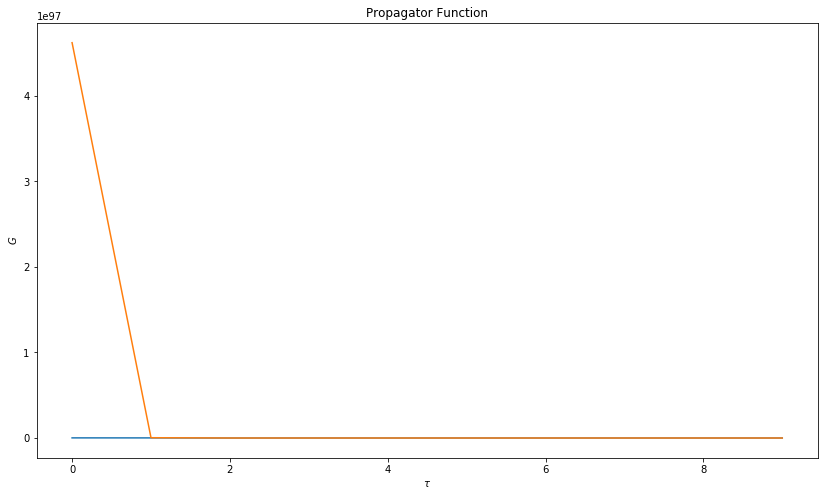

In [350]:
figure2 = plt.figure(figsize = (14,8))
plt.title("Propagator Function")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G$")
for i in range(T_it-2,T_it):
    plt.plot(np.arange(0,T),(G_s[i]))

**Plotting the last propagator found (last iteration)**

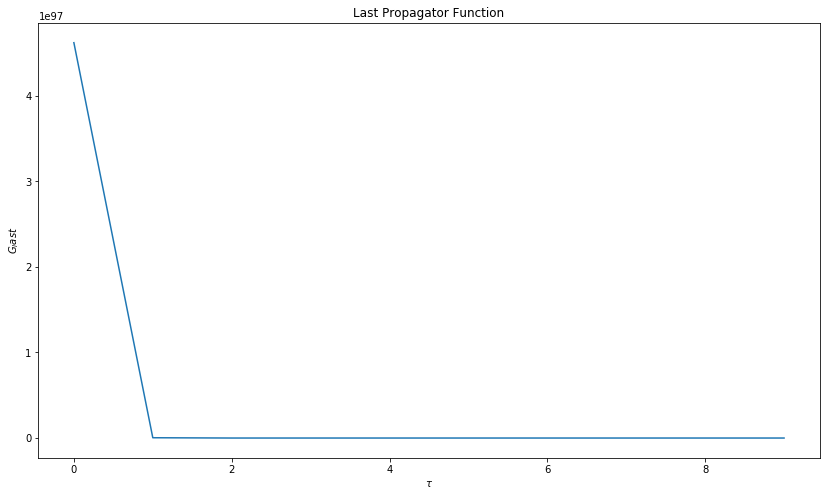

In [351]:
figure3 = plt.figure(figsize = (14,8))
plt.title("Last Propagator Function")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G_last$")
plt.plot(np.arange(0,T), G_s[T_it-1])
plt.show()

In [352]:
G_s[T_it-1]

array([ 4.62008431e+97,  3.45158718e+94, -1.36171212e+91,  3.88542161e+87,
       -7.30063808e+85,  6.25473512e+84,  1.22725500e+86,  9.78242202e+86,
       -1.28460590e+87, -1.56184811e+84])

**Plotting the Euclidean Distance between sucessive propagators in G_s**

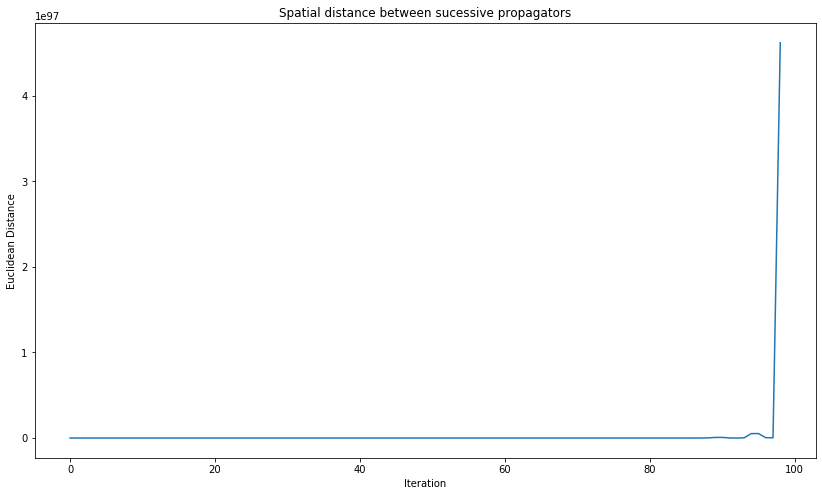

In [353]:
from scipy.spatial.distance import euclidean
figure4 = plt.figure(figsize = (14,8))
plt.title("Spatial distance between sucessive propagators")
plt.xlabel(r"Iteration")
plt.ylabel(r"Euclidean Distance")

distances = np.ones(T_it-1)

for i in range(0,T_it-1):
    distances[i] = euclidean(G_s[i],G_s[i+1])
    
plt.plot(np.arange(0,T_it-1),distances)

**Plotting the ACF of the Noise Trader**

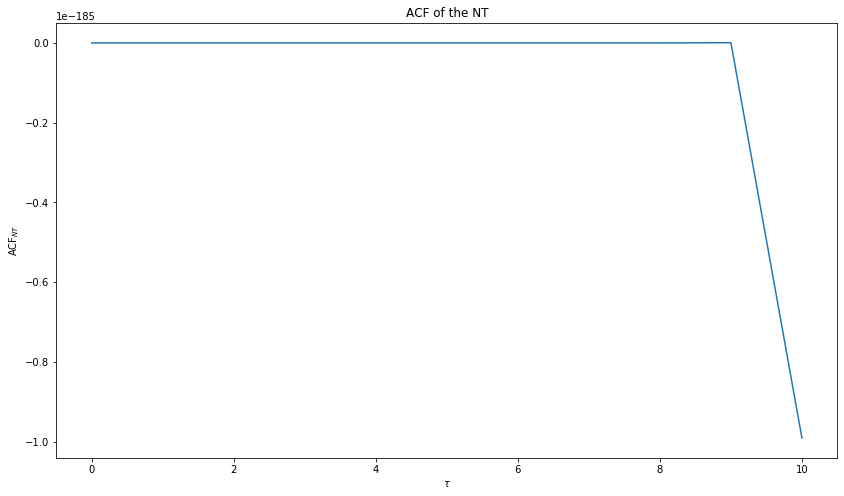

In [354]:
figure5 = plt.figure(figsize = (14,8))
plt.title("ACF of the NT")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathsf{ACF}_{NT}$")
plt.plot(np.arange(0,T+1), ACFs_NT[T_it-1][0,:])
plt.show()

**Plotting ACF of the Informed Trader**

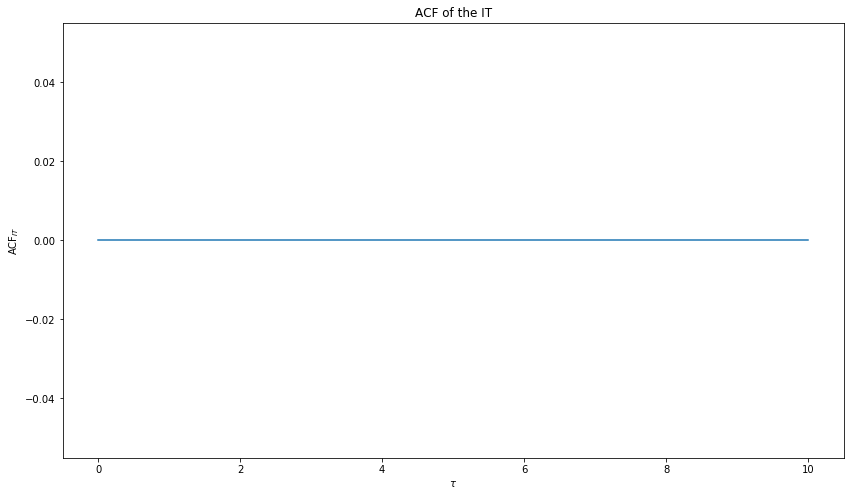

In [355]:
figure6 = plt.figure(figsize = (14,8))
plt.title("ACF of the IT")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathsf{ACF}_{IT}$")
plt.plot(np.arange(0,T+1), ACFs_IT[T_it-1][0,:])
plt.show()

**Plotting the ACF of the Total Excess Demand**

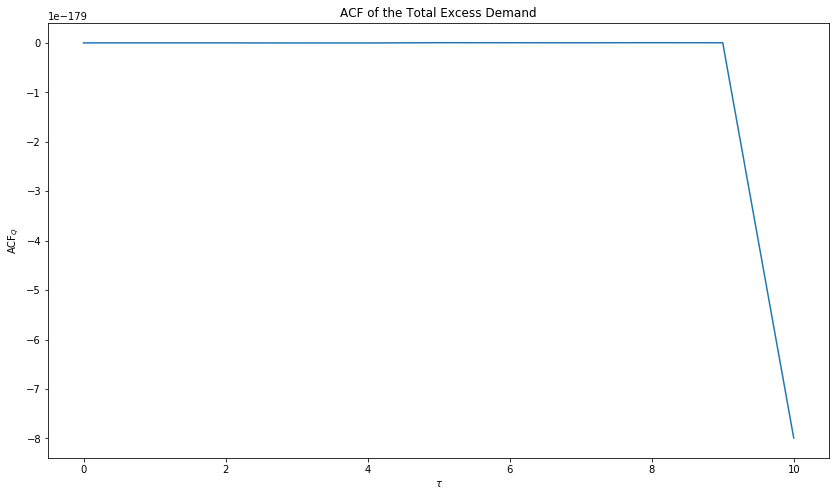

In [356]:
figure7 = plt.figure(figsize = (14,8))
plt.title("ACF of the Total Excess Demand")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathsf{ACF}_{Q}$")
plt.plot(np.arange(0,T+1), ACFs_Q[T_it-1][0,:])
plt.show()

## Superposition of ACFs - Rational Noise Trader

**ACF_NT and ACF_Q**

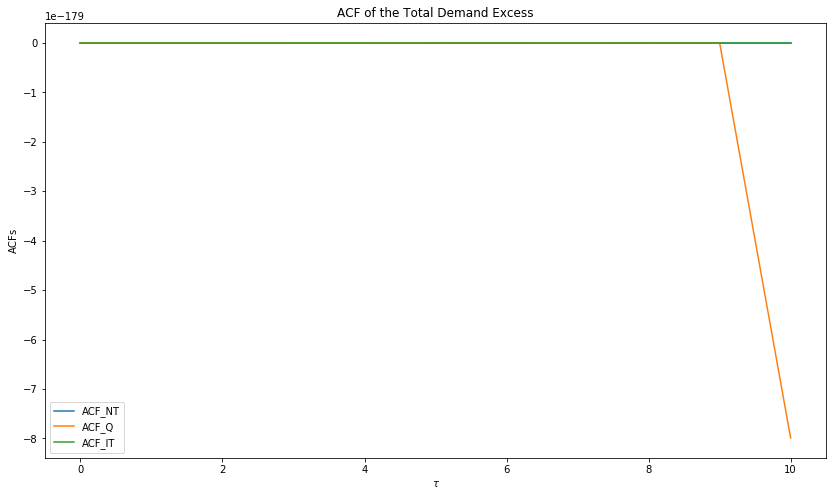

In [357]:
figure8 = plt.figure(figsize = (14,8))
plt.title("ACF of the Total Demand Excess")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathsf{ACFs}$")
plt.plot(np.arange(0,T+1), ACFs_NT[T_it-1][0,:], label = "ACF_NT")
plt.plot(np.arange(0,T+1), ACFs_Q[T_it-1][0,:], label = "ACF_Q")
plt.plot(np.arange(0,T+1), ACFs_IT[T_it-1][0,:], label = "ACF_IT")
plt.legend()
plt.show()

## Analysis of Results - Irrational Noise Trader

In [358]:
T = 10
T_it = 200
G_0_seed = 50
alpha_G = 0.4
tau_MU = 20
tau_NT = 10

G_Irrational, G_s_Irrational, ACFs_Q_Irrational = numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, tau_MU, tau_NT)

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20

This is iteration: 21

This is iteration: 22

This is iteration: 23

This is iteration: 24

This is iteration: 25

This is iteration: 26

This is iteration: 27

This is iteration: 28

This is iteration: 29

This is iteration: 30

This is iteration: 31

This is iteration: 32

This is iteration: 33

This is iteration: 34

This is iteration: 35

This is iteration: 36

This is iteration: 37

This is iteration: 38

This is iteration: 39

This is iteration: 40

This is iteration: 41

This is iteration: 42

This is iteration: 43

This is iteration: 4

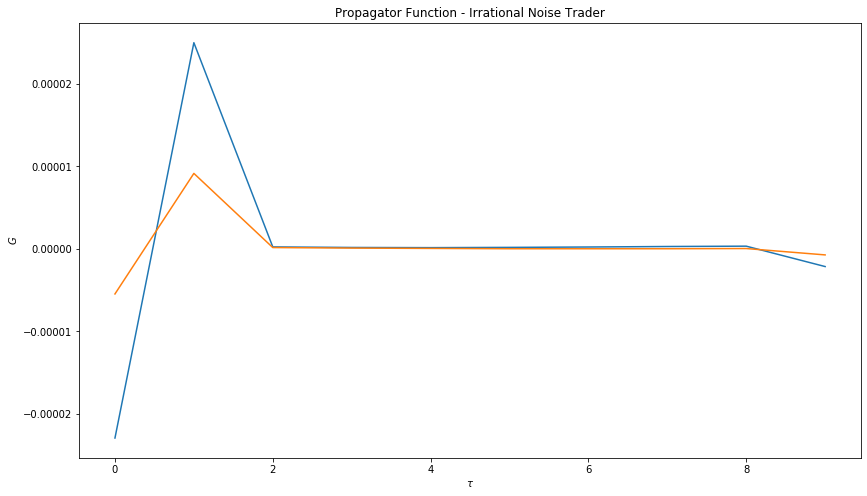

In [359]:
figure9 = plt.figure(figsize = (14,8))
plt.title("Propagator Function - Irrational Noise Trader")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G$")
for i in range(T_it-2,T_it):
    plt.plot(np.arange(0,T),G_s_Irrational[i])
plt.show()

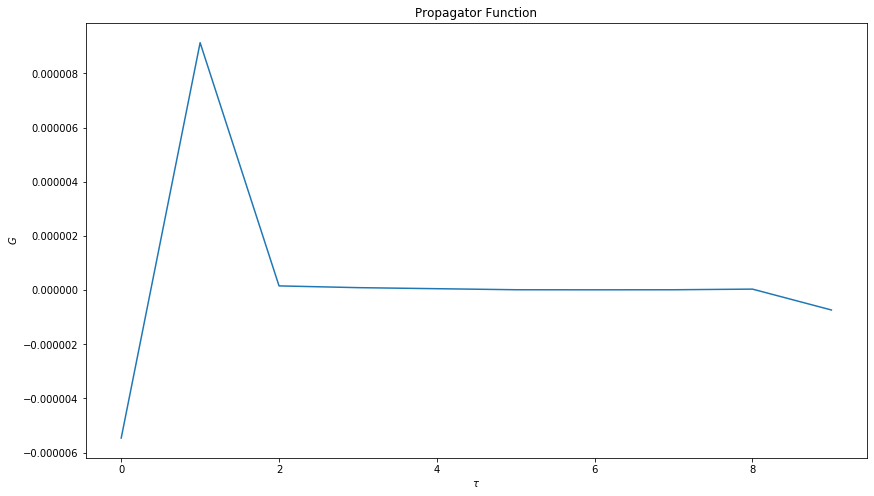

In [360]:
figure10 = plt.figure(figsize = (14,8))
plt.title("Propagator Function")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G$")
for i in range(T_it-1,T_it):
    plt.plot(np.arange(0,T),(G_s_Irrational[i]))

## Debugging

**G**

In [361]:
G =  return_G(G_0_seed, alpha_G, 5)
G

array([[50.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [20.  , 50.  ,  0.  ,  0.  ,  0.  ],
       [ 8.  , 20.  , 50.  ,  0.  ,  0.  ],
       [ 3.2 ,  8.  , 20.  , 50.  ,  0.  ],
       [ 1.28,  3.2 ,  8.  , 20.  , 50.  ]])

**G_futpast**

In [362]:
G_futpast = return_G_futpast(G)

In [363]:
G_futpast

array([[ 0.  ,  1.28,  3.2 ,  8.  , 20.  ],
       [ 0.  ,  0.  ,  1.28,  3.2 ,  8.  ],
       [ 0.  ,  0.  ,  0.  ,  1.28,  3.2 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.28],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

**Lag Matrix**

In [371]:
T = 5
L = np.zeros((T,T+1))
L[:T,:T] = np.identity(T)

In [372]:
L

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [373]:
F_MU = -1*np.flip(np.flip(Mforecast('mark','MU',[1,_],T,2*T,_),1),0)

In [374]:
F_MU

array([[ 0.00673795, -0.        , -0.        , -0.        , -0.        ],
       [ 0.01831564, -0.        , -0.        , -0.        , -0.        ],
       [ 0.04978707, -0.        , -0.        , -0.        , -0.        ],
       [ 0.13533528, -0.        , -0.        , -0.        , -0.        ],
       [ 0.36787944, -0.        , -0.        , -0.        , -0.        ]])